In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import yfinance as yf

In [3]:
# AAPL hisse senedi sembolü
symbol = "AAPL"

# Tarih aralığını belirleyin (örneğin, son 1 yıl)
start_date = "2022-01-01"
end_date = "2023-01-01"

period = "5y"
interval = "1d"

# Verileri çek
# data = yf.download(symbol, start=start_date, end=end_date)
data = yf.download(symbol, period=period, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Veriyi göster
print(data.head())

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2018-12-17  41.362499  42.087502  40.682499  40.985001  39.337856  177151600
2018-12-18  41.345001  41.882500  41.097500  41.517502  39.848953  135366000
2018-12-19  41.500000  41.862499  39.772499  40.222500  38.605995  196189200
2018-12-20  40.099998  40.527500  38.825001  39.207500  37.631786  259092000
2018-12-21  39.215000  39.540001  37.407501  37.682499  36.168076  382978400


In [5]:
# Önceki gün değerlerini içeren sütunları ekleyin
data['Prev Open'] = data['Open'].shift(1)
data['Prev High'] = data['High'].shift(1)
data['Prev Low'] = data['Low'].shift(1)
data['Prev Close'] = data['Close'].shift(1)
data['Prev Volume'] = data['Volume'].shift(1)

# İlk gün için NaN değerleri temizleyin
data = data.dropna()

print(data.head(5))

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2018-12-18  41.345001  41.882500  41.097500  41.517502  39.848953  135366000   
2018-12-19  41.500000  41.862499  39.772499  40.222500  38.605995  196189200   
2018-12-20  40.099998  40.527500  38.825001  39.207500  37.631786  259092000   
2018-12-21  39.215000  39.540001  37.407501  37.682499  36.168076  382978400   
2018-12-24  37.037498  37.887501  36.647499  36.707500  35.232258  148676800   

            Prev Open  Prev High   Prev Low  Prev Close  Prev Volume  
Date                                                                  
2018-12-18  41.362499  42.087502  40.682499   40.985001  177151600.0  
2018-12-19  41.345001  41.882500  41.097500   41.517502  135366000.0  
2018-12-20  41.500000  41.862499  39.772499   40.222500  196189200.0  
2018-12-21  40.099998  40.527500  38.825001   39.207500  259092000.0  
2018-12-24  3

In [6]:
def calculate_adx_di(df, len_param=14):
    """
    Verilen bir DataFrame'e ADX ve DIPlus, DIMinus sütunlarını ekleyen fonksiyon.

    Parameters:
    - df: DataFrame, Hissedarlık verilerini içeren DataFrame.
    - len_param: int, SmoothedTrueRange ve ADX hesaplamak için kullanılacak periyot.

    Returns:
    - df: DataFrame, Güncellenmiş DataFrame.
    """

    # TrueRange hesaplama
    df['TrueRange'] = df.apply(lambda row: max(row['Prev High'] - row['Prev Low'], abs(row['Prev High'] - df['Prev Close'].shift(1)[row.name]), abs(row['Prev Low'] - df['Prev Close'].shift(1)[row.name])), axis=1)

    # Directional Movement hesaplama
    df['DirectionalMovementPlus'] = df.apply(lambda row: max(row['Prev High'] - df['Prev High'].shift(1)[row.name], 0) if row['Prev High'] - df['Prev High'].shift(1)[row.name] > df['Prev Low'].shift(1)[row.name] - row['Prev Low'] else 0, axis=1)
    df['DirectionalMovementMinus'] = df.apply(lambda row: max(df['Prev Low'].shift(1)[row.name] - row['Prev Low'], 0) if df['Prev Low'].shift(1)[row.name] - row['Prev Low'] > row['Prev High'] - df['Prev High'].shift(1)[row.name] else 0, axis=1)

    # # Smoothed TrueRange ve Directional Movement hesaplama
    # df['SmoothedTrueRange'] = df['TrueRange'].rolling(window=len_param).mean()
    # df['SmoothedDirectionalMovementPlus'] = df['DirectionalMovementPlus'].rolling(window=len_param).mean()
    # df['SmoothedDirectionalMovementMinus'] = df['DirectionalMovementMinus'].rolling(window=len_param).mean()
    # Smoothed TrueRange ve Directional Movement hesaplama
    df['SmoothedTrueRange'] = 0.0
    df['SmoothedDirectionalMovementPlus'] = 0.0
    df['SmoothedDirectionalMovementMinus'] = 0.0

    for i in range(1, len(df)):
        df.at[df.index[i], 'SmoothedTrueRange'] = df.at[df.index[i-1], 'SmoothedTrueRange'] - (df.at[df.index[i-1], 'SmoothedTrueRange'] / len_param) + df.at[df.index[i], 'TrueRange']
        df.at[df.index[i], 'SmoothedDirectionalMovementPlus'] = df.at[df.index[i-1], 'SmoothedDirectionalMovementPlus'] - (df.at[df.index[i-1], 'SmoothedDirectionalMovementPlus'] / len_param) + df.at[df.index[i], 'DirectionalMovementPlus']
        df.at[df.index[i], 'SmoothedDirectionalMovementMinus'] = df.at[df.index[i-1], 'SmoothedDirectionalMovementMinus'] - (df.at[df.index[i-1], 'SmoothedDirectionalMovementMinus'] / len_param) + df.at[df.index[i], 'DirectionalMovementMinus']

    # DIPlus, DIMinus ve ADX hesaplama
    df['DIPlus'] = df['SmoothedDirectionalMovementPlus'] / df['SmoothedTrueRange'] * 100
    df['DIMinus'] = df['SmoothedDirectionalMovementMinus'] / df['SmoothedTrueRange'] * 100
    df['DX'] = abs(df['DIPlus'] - df['DIMinus']) / (df['DIPlus'] + df['DIMinus']) * 100
    df['ADX'] = df['DX'].rolling(window=len_param).mean()

    # Gereksiz sütunları düşürme
    df = df.drop(['TrueRange', 'DirectionalMovementPlus', 'DirectionalMovementMinus', 'SmoothedTrueRange', 'SmoothedDirectionalMovementPlus', 'SmoothedDirectionalMovementMinus', 'DX'], axis=1)

    # İlk 14 satırın NaN değerlerini temizleme
    df = df.dropna()

    return df

# data = calculate_adx_di(data)

In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,Prev Open,Prev High,Prev Low,Prev Close,Prev Volume
Date,,,,,,,,,,,
2023-12-11,193.110001,193.490005,191.419998,193.179993,193.179993,60943700,194.199997,195.990005,193.669998,195.710007,53377300.0
2023-12-12,193.080002,194.720001,191.720001,194.710007,194.710007,52696900,193.110001,193.490005,191.419998,193.179993,60943700.0
2023-12-13,195.089996,198.000000,194.850006,197.960007,197.960007,70404200,193.080002,194.720001,191.720001,194.710007,52696900.0
2023-12-14,198.020004,199.619995,196.160004,198.110001,198.110001,66831600,195.089996,198.000000,194.850006,197.960007,70404200.0
2023-12-15,197.529999,198.399994,197.000000,197.570007,197.570007,128256700,198.020004,199.619995,196.160004,198.110001,66831600.0


In [8]:
# X = data[['Prev Open', 'Prev High', 'Prev Low', 'Prev Close', 'Prev Volume', 'DIPlus', 'DIMinus', 'ADX']].values
X = data[['Prev Open', 'Prev High', 'Prev Low', 'Prev Close', 'Prev Volume']].values

In [9]:
y = data[['Close']].values

In [10]:
# define the size of the training set
train_size = int(len(data) * 0.8)

In [11]:
# split the data into training and testing sets
X_train, X_test = X[:train_size, :], X[train_size:, :]
y_train, y_test = y[:train_size], y[train_size:]

In [12]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1006, 5)
(1006, 1)
(252, 5)
(252, 1)


In [13]:
from sklearn.preprocessing import MinMaxScaler

# normalize the data using MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X_train = X_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train)

X_test = X_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

# Eğitim ve test setlerini göster
print("Eğitim seti:", X_train.shape, y_train.shape)
print("Test seti:", X_test.shape, y_test.shape)

Eğitim seti: (1006, 5) (1006, 1)
Test seti: (252, 5) (252, 1)


In [14]:
# reshape the input data into 3D format (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [15]:
# Eğitim ve test setlerini göster
print("Eğitim seti:", X_train.shape, y_train.shape)
print("Test seti:", X_test.shape, y_test.shape)

Eğitim seti: (1006, 1, 5) (1006, 1)
Test seti: (252, 1, 5) (252, 1)


In [16]:
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense

# define the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            42400     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [18]:
# train the model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

model_his = model.fit(X_train, y_train, epochs=100, batch_size=4, validation_data=(X_test, y_test), verbose=1, callbacks=[checkpoint])

Epoch 1/100
247/252 [============================>.] - ETA: 0s - loss: 0.1092
Epoch 1: val_loss improved from inf to 0.05796, saving model to best_model.h5
252/252 [==============================] - 6s 8ms/step - loss: 0.1080 - val_loss: 0.0580
Epoch 2/100
249/252 [============================>.] - ETA: 0s - loss: 0.0451
Epoch 2: val_loss improved from 0.05796 to 0.02377, saving model to best_model.h5
252/252 [==============================] - 1s 4ms/step - loss: 0.0450 - val_loss: 0.0238
Epoch 3/100
252/252 [==============================] - ETA: 0s - loss: 0.0392
Epoch 3: val_loss did not improve from 0.02377
252/252 [==============================] - 1s 4ms/step - loss: 0.0392 - val_loss: 0.0272
Epoch 4/100
248/252 [============================>.] - ETA: 0s - loss: 0.0363
Epoch 4: val_loss did not improve from 0.02377
252/252 [==============================] - 1s 4ms/step - loss: 0.0364 - val_loss: 0.0476
Epoch 5/100
252/252 [==============================] - ETA: 0s - loss: 0.0361


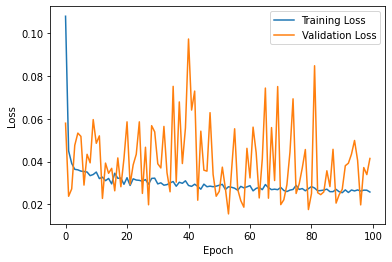

In [19]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(model_his.history['loss'], label='Training Loss')
plt.plot(model_his.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
preds = model.predict(X_test)

In [21]:
preds = y_scaler.inverse_transform(preds)
y_test = y_scaler.inverse_transform(y_test)

In [22]:
import matplotlib.pyplot as plt
import numpy as np

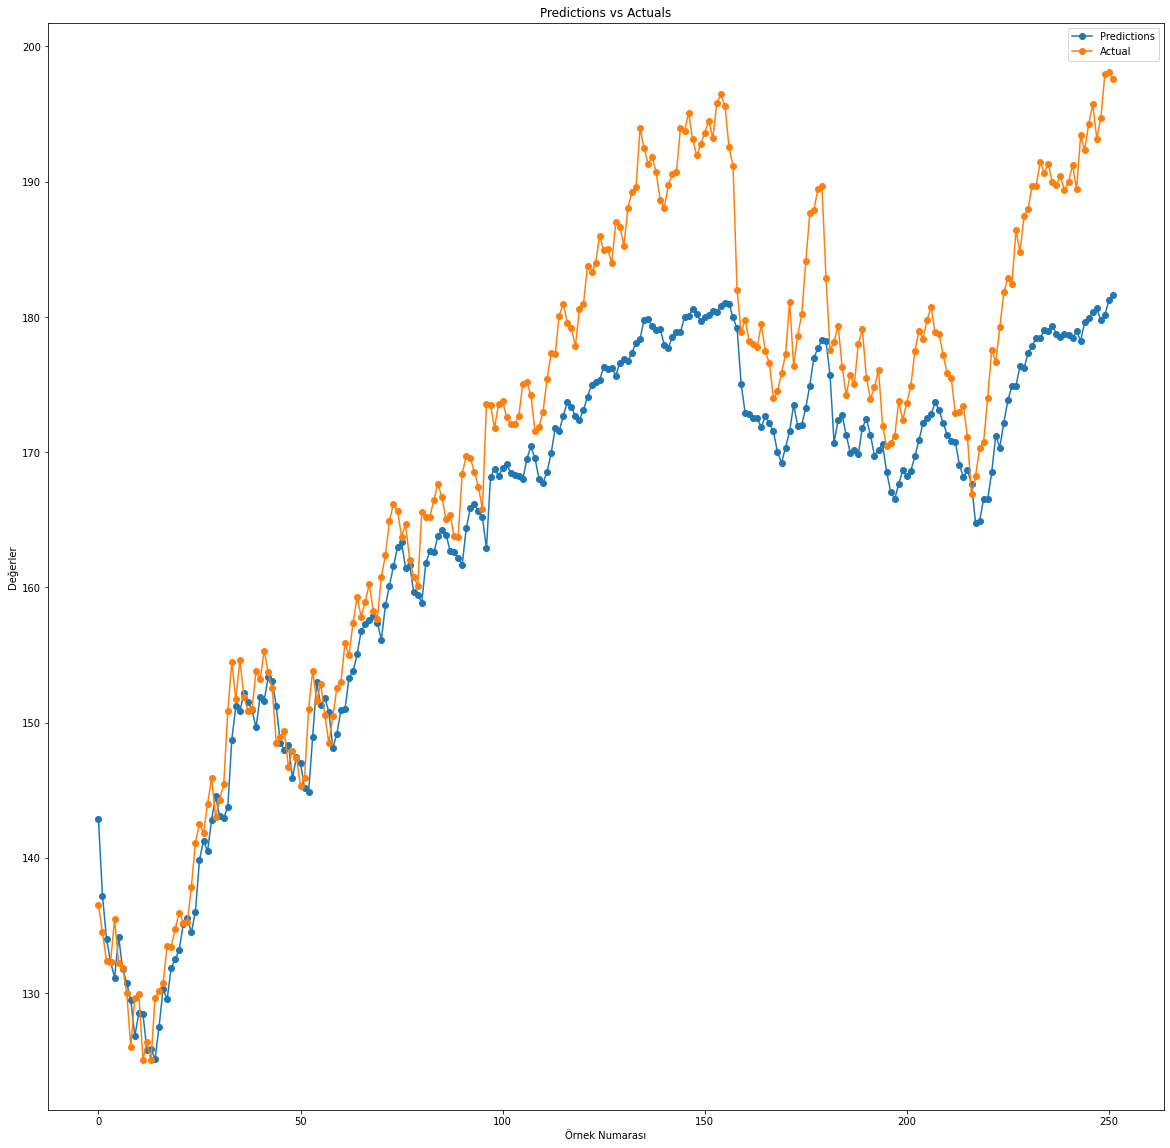

In [23]:
# X eksenindeki değerler
x_values = np.arange(len(preds))


plt.figure(figsize=(20, 20))


# Çizgi grafikleri oluştur
plt.plot(x_values, preds, label='Predictions', marker='o')
plt.plot(x_values, y_test, label='Actual', marker='o')

# Eksen etiketleri
plt.xlabel('Örnek Numarası')
plt.ylabel('Değerler')

# Başlık
plt.title('Predictions vs Actuals')

# İlgili yeri göster
plt.legend()

plt.savefig('example_plot.png')

# Grafik göster
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error as mae

# calculate MAE 
error = mae(preds, y_test) 
  
# display 
print("Mean absolute error : " + str(error)) 

Mean absolute error : 6.073373552352662


In [25]:
from sklearn.metrics import mean_absolute_percentage_error

error = mean_absolute_percentage_error(preds, y_test)
print("Mean absolute error : " + str(error)) 

Mean absolute error : 0.035580735005206254


In [26]:
for index, value in enumerate(preds):
    print(value, y_test[index])

[142.87584] [136.5]
[137.20644] [134.50999451]
[134.02946] [132.36999512]
[132.3114] [132.30000305]
[131.14294] [135.44999695]
[134.15234] [132.22999573]
[131.77228] [131.86000061]
[130.7396] [130.02999878]
[129.49649] [126.04000092]
[126.80579] [129.61000061]
[128.52963] [129.92999268]
[128.46298] [125.06999969]
[125.81846] [126.36000061]
[125.8838] [125.01999664]
[125.10125] [129.61999512]
[127.49379] [130.1499939]
[130.29872] [130.72999573]
[129.52638] [133.49000549]
[131.88379] [133.41000366]
[132.48586] [134.75999451]
[133.21709] [135.94000244]
[135.1287] [135.21000671]
[135.51582] [135.27000427]
[134.47931] [137.86999512]
[136.02881] [141.11000061]
[139.85266] [142.52999878]
[141.27888] [141.86000061]
[140.47063] [143.96000671]
[142.8313] [145.92999268]
[144.54597] [143.]
[143.0761] [144.28999329]
[142.96463] [145.42999268]
[143.72412] [150.82000732]
[148.74231] [154.5]
[151.21893] [151.72999573]
[150.83667] [154.6499939]
[152.18869] [151.91999817]
[151.49277] [150.86999512]
[150